In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import random
import pandas as pd
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from pycaret.anomaly import *

from pyod.models.abod import ABOD

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# Random Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(69) # Seed 고정

## Data Load

In [5]:
data_path = '/content/drive/MyDrive/AI_SPARK/dataset'
train = pd.read_csv(data_path+'/train_data.csv')
test = pd.read_csv(data_path+'/test_data.csv')

In [6]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [7]:
test

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,0
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,0
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,0
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,0
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,0
...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7


## EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [9]:
train.isnull().sum()

air_inflow       0
air_end_temp     0
out_pressure     0
motor_current    0
motor_rpm        0
motor_temp       0
motor_vibe       0
type             0
dtype: int64

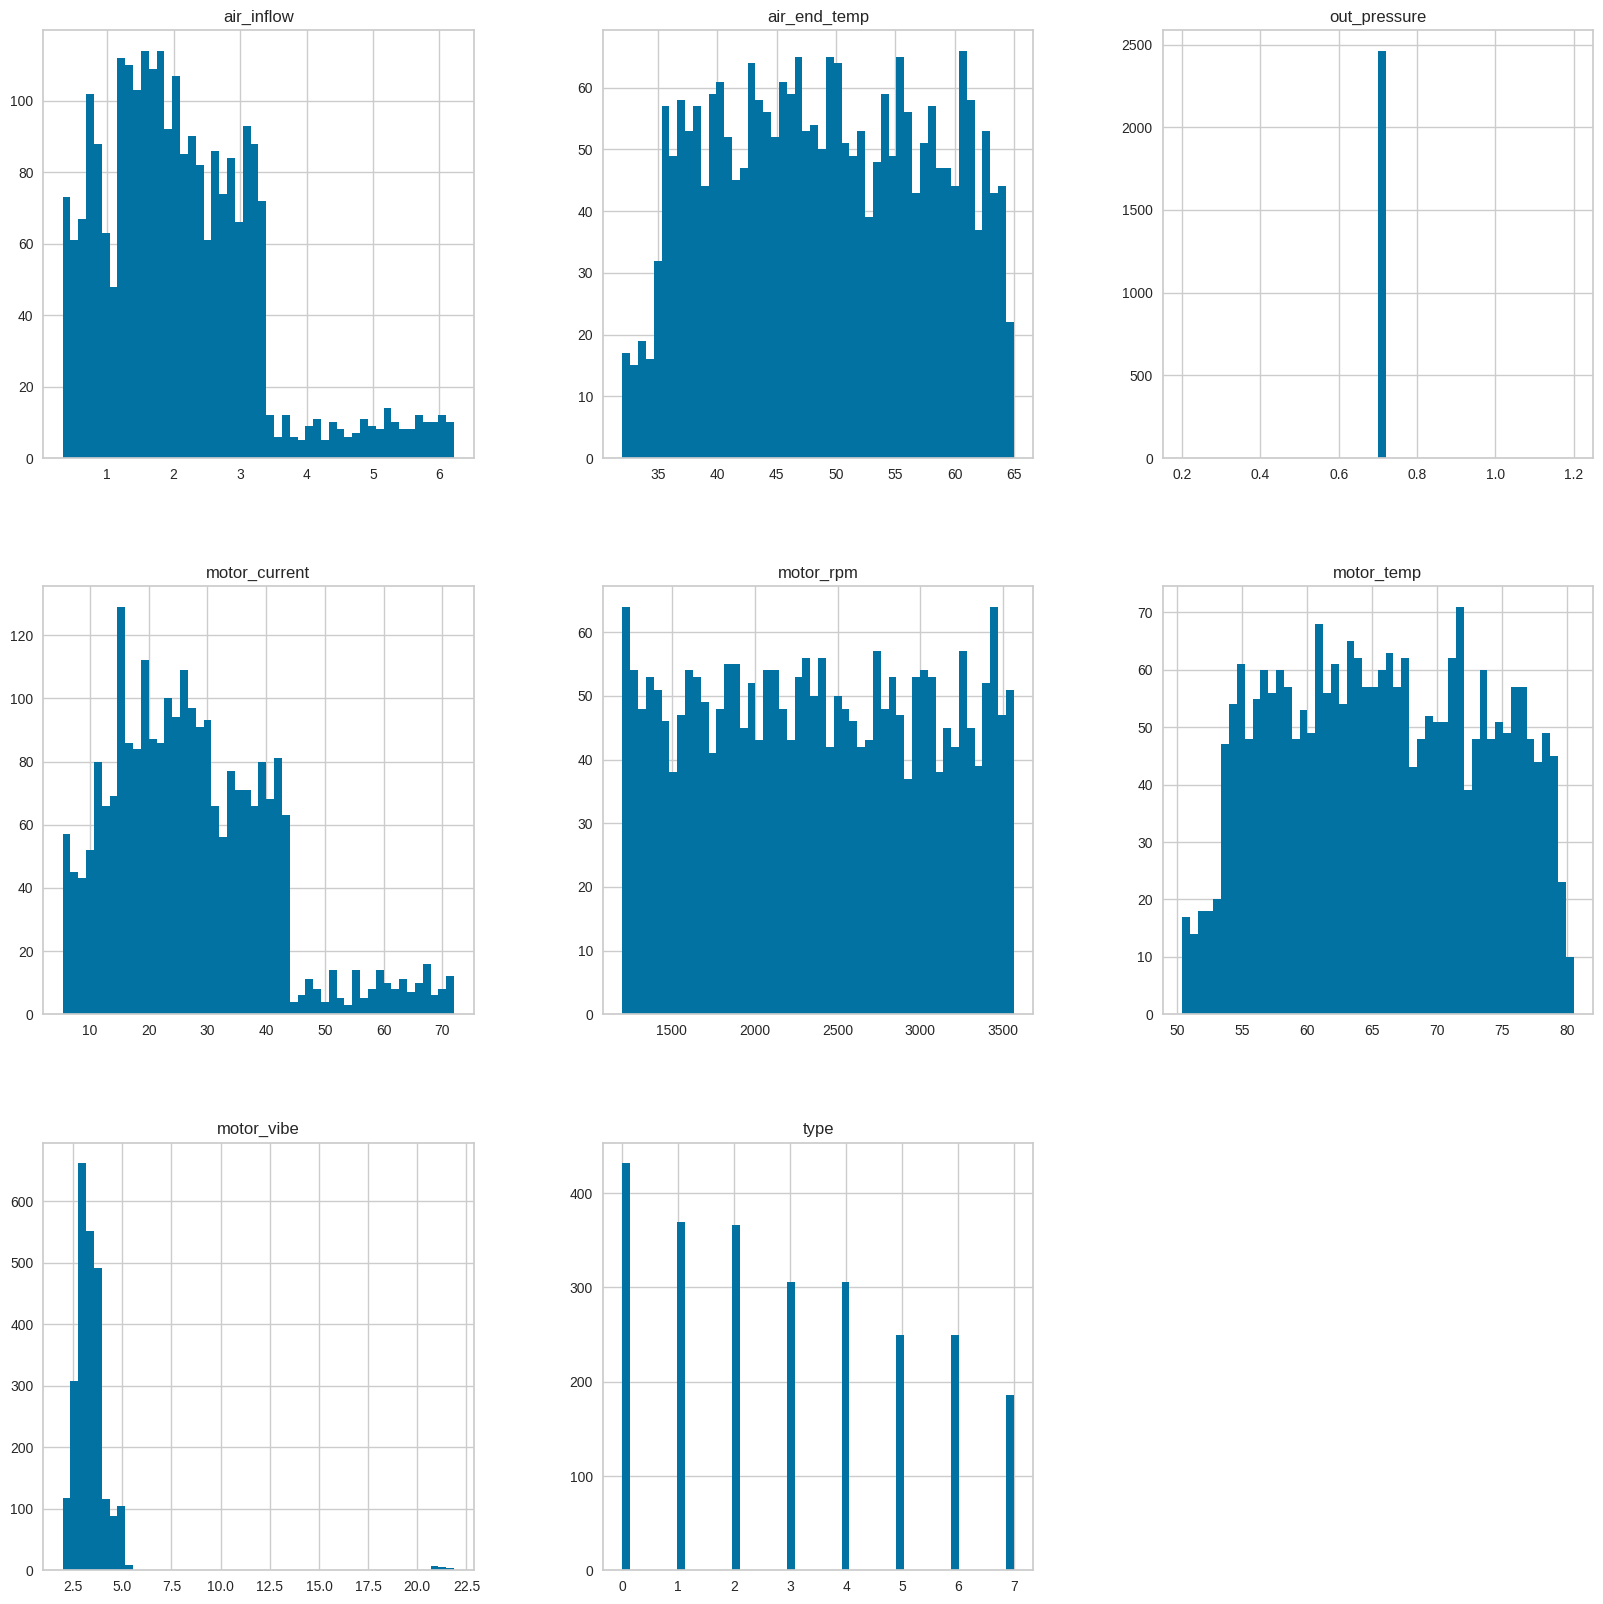

In [10]:
train.hist(bins = 50, figsize = (20,20))
plt.show()

In [11]:
# 이상치로 판단되는 20 이상의 값 개수 확인
len(train.loc[train['motor_vibe'] >= 20])

16

In [12]:
train.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
count,2463.000000,2463.000000,2.463000e+03,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000
mean,2.128843,49.001137,7.000000e-01,27.490715,2372.576939,65.766707,3.452972,2.957369
std,1.202328,8.725091,1.110448e-16,13.604597,687.870774,7.797152,1.576386,2.230113
min,0.330000,32.030000,7.000000e-01,5.340000,1201.000000,50.360000,1.970000,0.000000
25%,1.280000,41.600000,7.000000e-01,17.110000,1784.500000,59.150000,2.880000,1.000000
50%,1.960000,48.980000,7.000000e-01,25.850000,2358.000000,65.640000,3.260000,3.000000
75%,2.820000,56.355000,7.000000e-01,36.000000,2971.000000,72.275000,3.730000,5.000000
max,6.220000,64.960000,7.000000e-01,72.000000,3564.000000,80.520000,21.870000,7.000000


## Pre-Processing

#### 1) 이상치 처리

In [13]:
train_ex = train[train.motor_vibe < 20]
train_ex

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [14]:
# motor_vibe 칼럼에서 이상치 제외 최대값 확인
max(train_ex['motor_vibe'])

5.18

In [15]:
# 이상치로 판단되는 20 이상의 값을 5.18로 대체
train.loc[train['motor_vibe'] >= 20, 'motor_vibe'] = 5.18

In [16]:
# 최대값 확인
max(train['motor_vibe'])

5.18

In [17]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


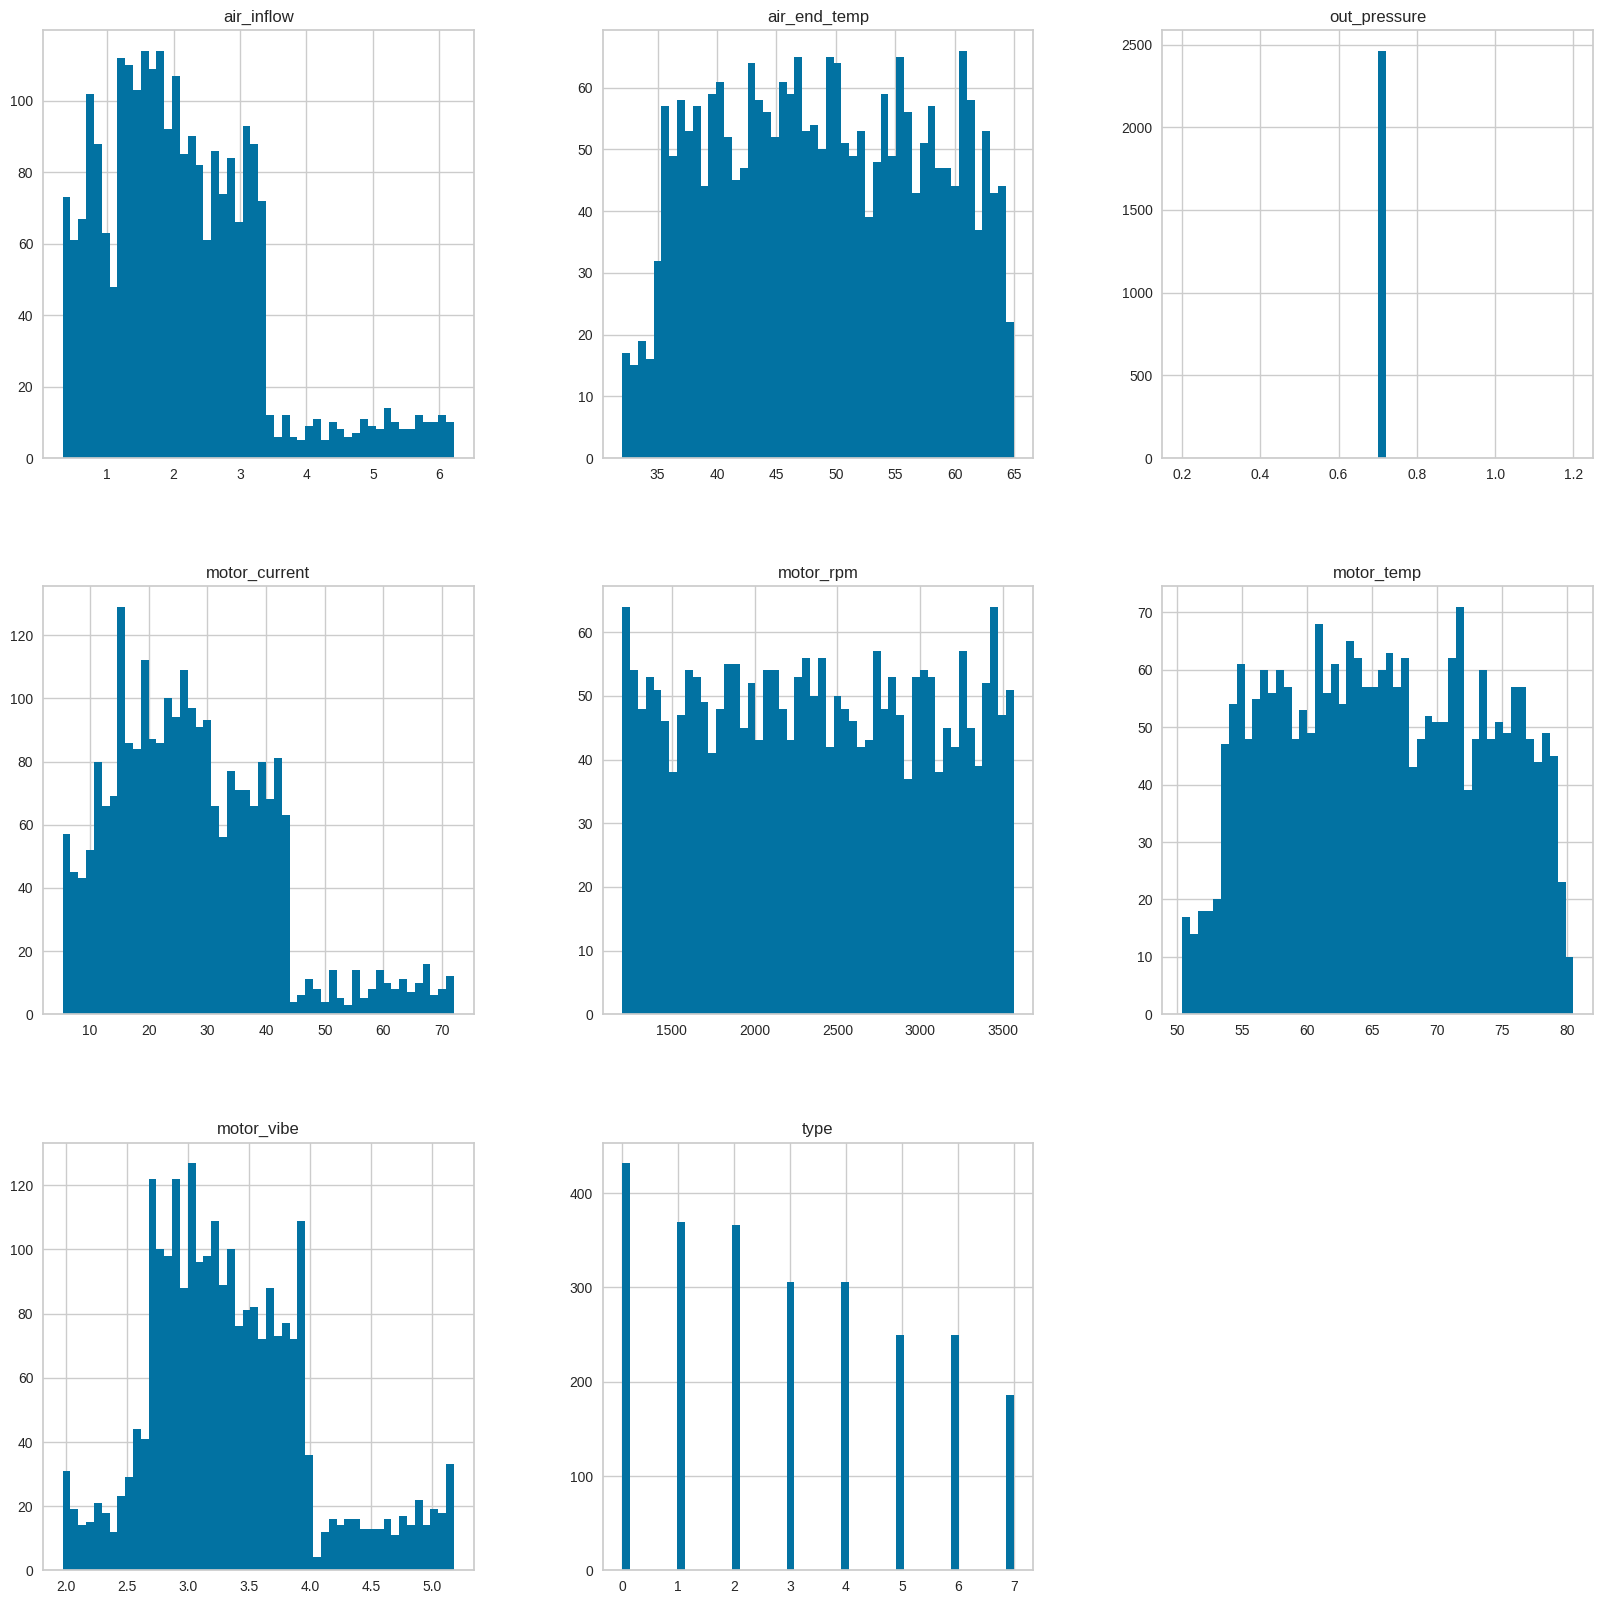

In [18]:
train.hist(bins = 50, figsize = (20,20))
plt.show()

#### 2) '마력' 변수 생성

In [19]:
train['마력'] = ''
test['마력'] = ''

In [20]:
train.loc[train['type'] == 0, '마력'] = 30
train.loc[train['type'] == 1, '마력'] = 20
train.loc[train['type'] == 2, '마력'] = 10
train.loc[train['type'] == 3, '마력'] = 50
train.loc[train['type'] == 4, '마력'] = 30
train.loc[train['type'] == 5, '마력'] = 30
train.loc[train['type'] == 6, '마력'] = 30
train.loc[train['type'] == 7, '마력'] = 30

test.loc[test['type'] == 0, '마력'] = 30
test.loc[test['type'] == 1, '마력'] = 20
test.loc[test['type'] == 2, '마력'] = 10
test.loc[test['type'] == 3, '마력'] = 50
test.loc[test['type'] == 4, '마력'] = 30
test.loc[test['type'] == 5, '마력'] = 30
test.loc[test['type'] == 6, '마력'] = 30
test.loc[test['type'] == 7, '마력'] = 30

In [21]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,마력
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0,30
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0,30
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0,30
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0,30
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0,30
...,...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7,30
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7,30
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7,30
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7,30


In [22]:
test

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,마력
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,0,30
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,0,30
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,0,30
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,0,30
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,0,30
...,...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7,30
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7,30
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7,30
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7,30


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
 8   마력             2463 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 173.3+ KB


In [24]:
train['마력'] = train['마력'].astype(int)
test['마력'] = test['마력'].astype(int)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
 8   마력             2463 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 173.3 KB


#### 3) 'type' 칼럼 get_dummies

In [26]:
train['type'] = train['type'].astype(str)
test['type'] = test['type'].astype(str)

In [27]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   마력             2463 non-null   int64  
 8   type_0         2463 non-null   uint8  
 9   type_1         2463 non-null   uint8  
 10  type_2         2463 non-null   uint8  
 11  type_3         2463 non-null   uint8  
 12  type_4         2463 non-null   uint8  
 13  type_5         2463 non-null   uint8  
 14  type_6         2463 non-null   uint8  
 15  type_7         2463 non-null   uint8  
dtypes: float64(7), int64(1), uint8(8)
memory usage: 173.3 KB


In [29]:
display(train.head())
display(test.head())

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,마력,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,30,1,0,0,0,0,0,0,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,30,1,0,0,0,0,0,0,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,30,1,0,0,0,0,0,0,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,30,1,0,0,0,0,0,0,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,30,1,0,0,0,0,0,0,0


,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,마력,type_0,type_1,type_2,type_3,type_4,type_5,type_6,type_7
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,30,1,0,0,0,0,0,0,0
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,30,1,0,0,0,0,0,0,0
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,30,1,0,0,0,0,0,0,0
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,30,1,0,0,0,0,0,0,0
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,30,1,0,0,0,0,0,0,0


## Train

In [30]:
anom = setup(data = train, verbose = 0, session_id = 69, normalize = True)

In [31]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [32]:
angle = ABOD()
angle.fit(train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

## Predict

In [33]:
pred_test = angle.predict(test)

In [34]:
pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
# 정상 (0), 이상 (1)
list(pred_test).count(0), list(pred_test).count(1)

(6678, 711)

## Submission

In [36]:
submit = pd.read_csv(data_path+'/answer_sample.csv')

In [37]:
submit['label'] = pred_test
submit.head()

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [38]:
submit.to_csv('/content/drive/MyDrive/AI_SPARK/submit/6.csv', index=False)